OBJECTIVE :
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

In [1]:
# Importing libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



In [3]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")

# (1) . Loading Data

In [4]:
# using the SQLite Table to read data.
con1 = sqlite3.connect('database.sqlite') 

In [5]:
# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con1)

In [6]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

In [7]:
print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

69.25890143662969

In [11]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [12]:
print(final.shape)

(364171, 10)


In [13]:
final[30:50]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040  and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [14]:
final = final[final['ProductId'] != '2841233731']

In [15]:
final = final[final['ProductId'] != '0006641040']

In [16]:
final.shape

(364136, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [17]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [18]:
words_to_keep = set(('not'))
stop -= words_to_keep

In [19]:
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

In [20]:
 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

In [21]:
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [22]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [23]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


#  (1). Bag of Words (BoW)

In [27]:
# Using only 4K (4000) rows for further analysis as my RAM is only 8 GB
my_final = final[0:4000]

In [29]:
my_final.shape

(4000, 11)

In [34]:
my_final['Score'].value_counts()

positive    3327
negative     673
Name: Score, dtype: int64

In [35]:
my_final['CleanedText'].values.shape

(4000,)

In [65]:
#BoW
count_vect = CountVectorizer(min_df=10) #in scikit-learn
final_counts = count_vect.fit_transform(my_final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 2010)
the number of unique words  2010


In [66]:
# Change sparse matrix to dense matrix
final_counts  = final_counts.toarray()

In [67]:
final_counts.shape

(4000, 2010)

In [40]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_counts)
print(standardized_data.shape)


(4000, 2010)


# t-SNE of Bag Of Words

In [41]:
my_final['Score'].shape

(4000,)

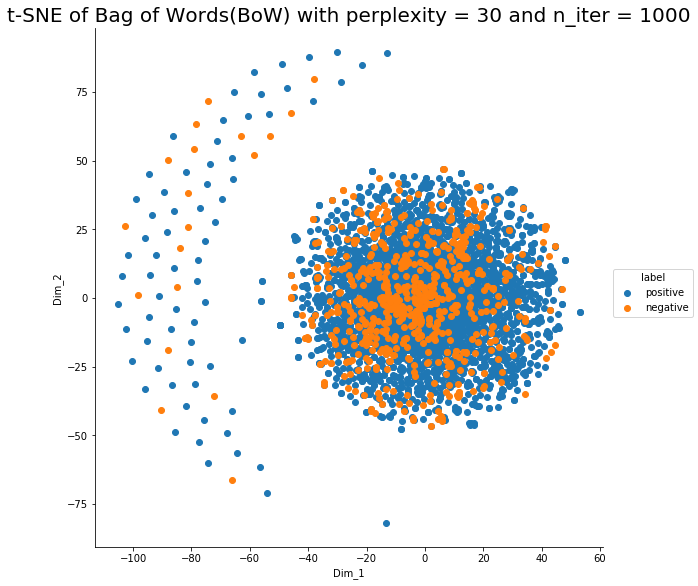

In [42]:
# TSNE

from sklearn.manifold import TSNE


model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 30 and n_iter = 1000',size=20)
plt.show()

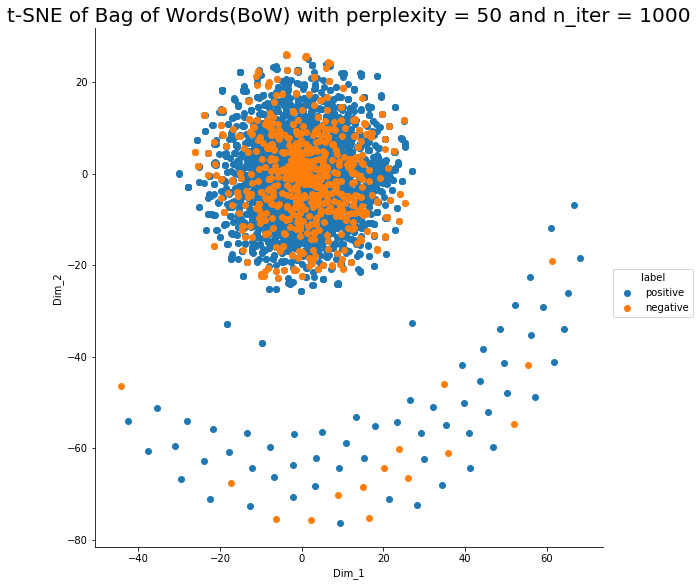

In [43]:
# t-SNE with perplexity = 50 and n_iter = 1000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=1000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 50 and n_iter = 1000',size=20)
plt.show()

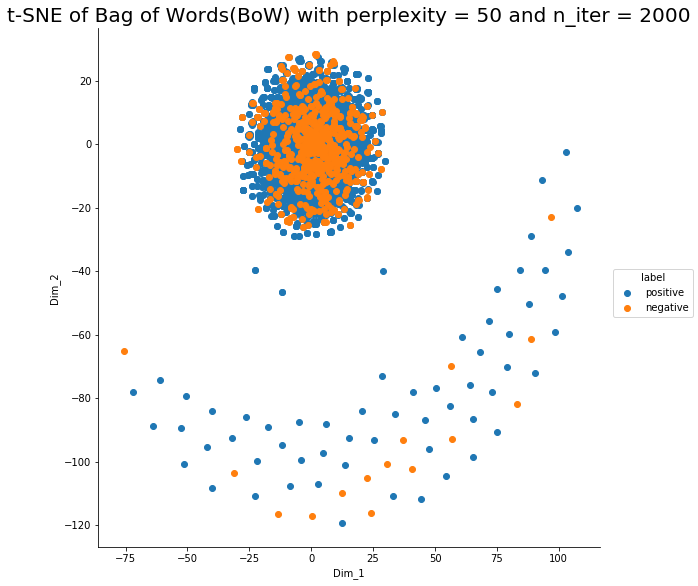

In [44]:
# t-SNE with perplexity = 50 and n_iter = 2000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=2000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 50 and n_iter = 2000',size=20)
plt.show()

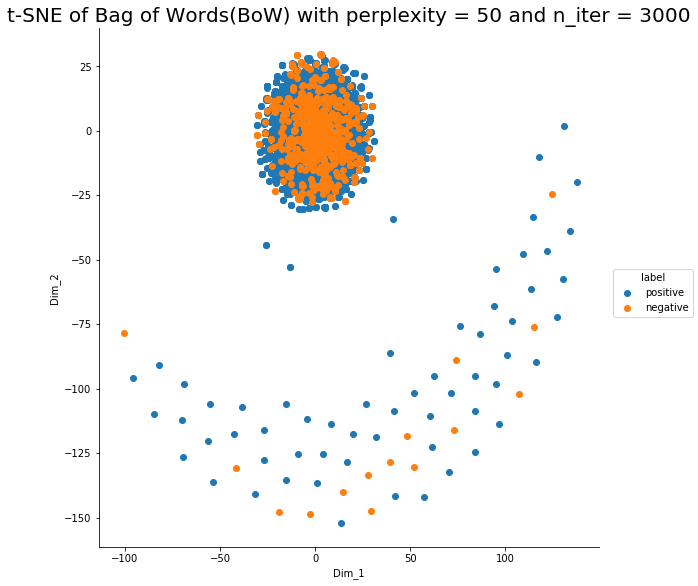

In [45]:
# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

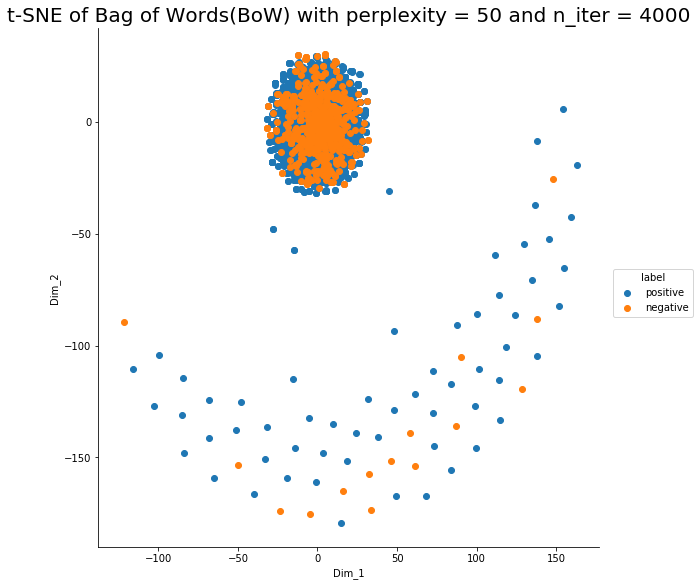

In [46]:
# t-SNE with perplexity = 50 and n_iter = 4000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=4000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 50 and n_iter = 4000',size=20)
plt.show()

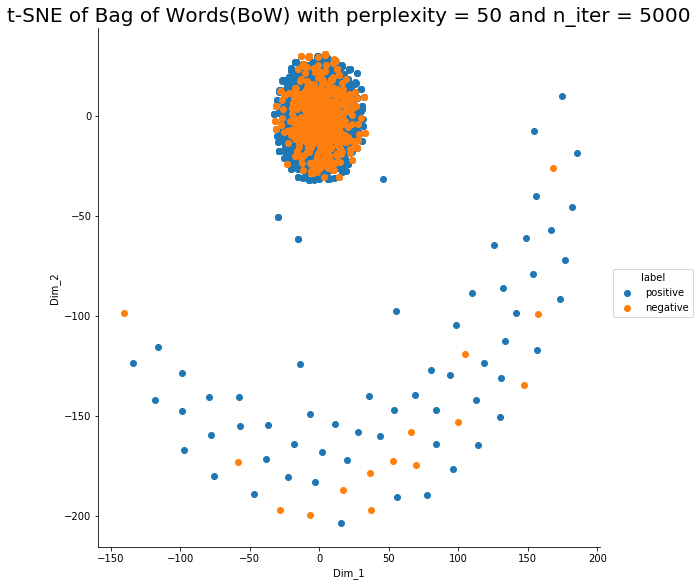

In [47]:
# t-SNE with perplexity = 50 and n_iter = 5000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 50 and n_iter = 5000',size=20)
plt.show()

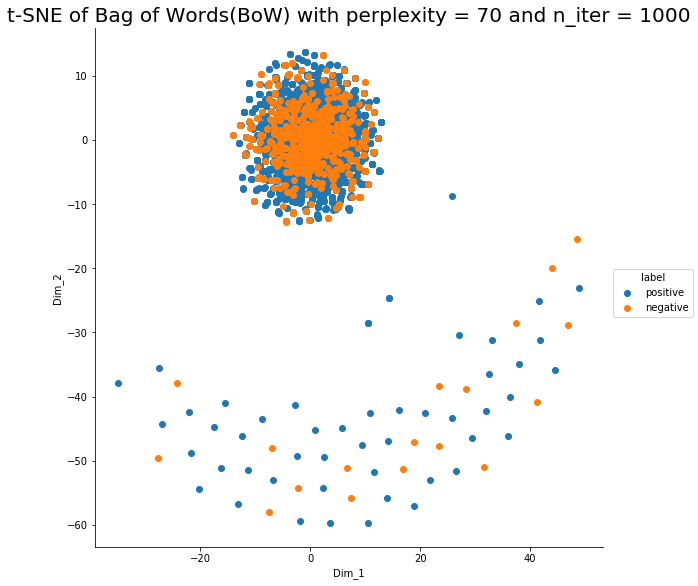

In [48]:
# t-SNE with perplexity = 70 and n_iter = 1000
model = TSNE(n_components=2, random_state=0, perplexity=70,  n_iter=1000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 70 and n_iter = 1000',size=20)
plt.show()

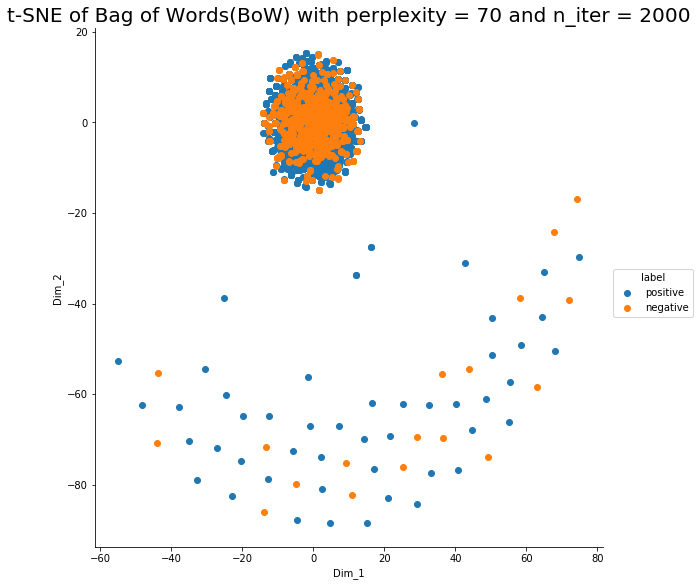

In [49]:
# t-SNE with perplexity = 70 and n_iter = 2000
model = TSNE(n_components=2, random_state=0, perplexity=70,  n_iter=2000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 70 and n_iter = 2000',size=20)
plt.show()

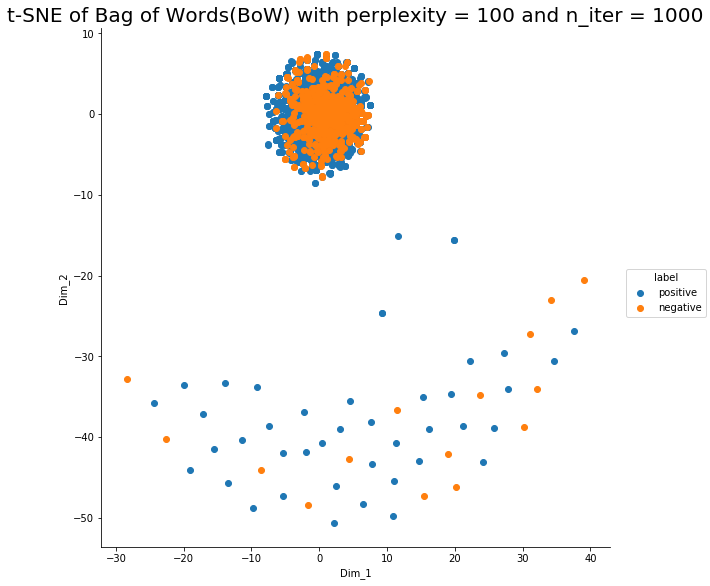

In [50]:
# t-SNE with perplexity = 100 and n_iter = 1000
model = TSNE(n_components=2, random_state=0, perplexity=100,  n_iter=1000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 100 and n_iter = 1000',size=20)
plt.show()

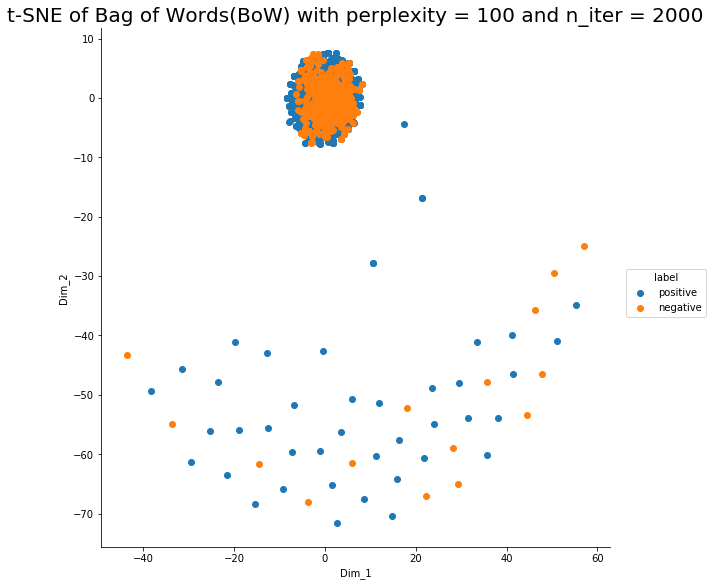

In [51]:
# t-SNE with perplexity = 100 and n_iter = 2000
model = TSNE(n_components=2, random_state=0, perplexity=100,  n_iter=2000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bag of Words(BoW) with perplexity = 100 and n_iter = 2000',size=20)
plt.show()

OBSERVATIONS :- After drawing and observing t-SNE plots for different values of perplexity and n_iter . It is good to draw t-SNE plots for further techniques using following hyper-parameters :

(1). perplexity = 50 

(2). n_iter = 3000

OBSERVATION FOR ABOVE PLOTS : From above plots it is clear that they are overlapping almost 90%-95% and it is very difficult to draw a line to classify the polarity of the reviews .

# Bi-Grams

In [63]:
#Bi-Gram
count_vect = CountVectorizer(ngram_range=(1,2),min_df=5 ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(my_final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 6369)
the number of unique words including both unigrams and bigrams  6369


In [69]:
# Change sparse matrix to dense matrix
final_bigram_counts  = final_bigram_counts.toarray()

In [70]:
final_bigram_counts.shape

(4000, 6369)

In [71]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_bigram_counts)
print(standardized_data.shape)


(4000, 6369)


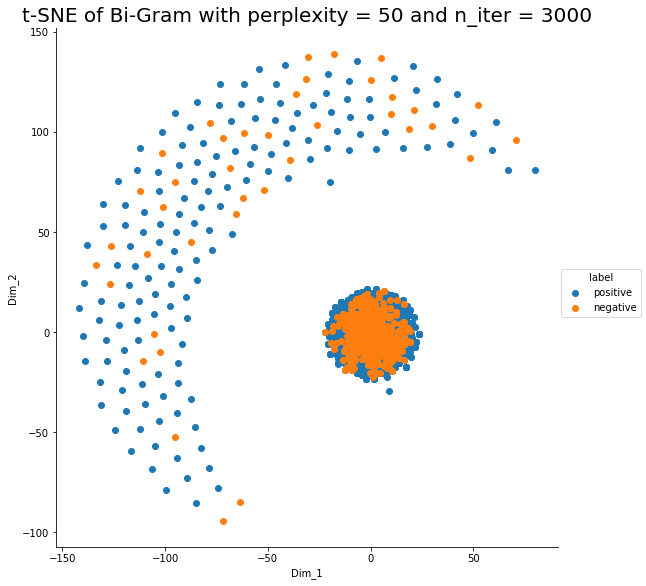

In [72]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Bi-Gram with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

OBSERVATION FOR ABOVE PLOT : From above plot it is clear that they are overlapping almost 90%-95% and it is very difficult to draw a line to classify the polarity of the reviews .

# (2). TF-IDF

In [86]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=5)
final_tf_idf = tf_idf_vect.fit_transform(my_final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4000, 6369)
the number of unique words including both unigrams and bigrams  6369


In [87]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[1000:1010])

some sample features(unique words in the corpus) ['coffe use', 'colada', 'cold', 'cold water', 'collect', 'colleg', 'colli', 'color', 'color dont', 'color ice']


In [88]:
# Change sparse matrix to dense matrix
final_tf_idf  = final_tf_idf.toarray()

In [89]:
final_tf_idf.shape

(4000, 6369)

In [90]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_tf_idf)
print(standardized_data.shape)

(4000, 6369)


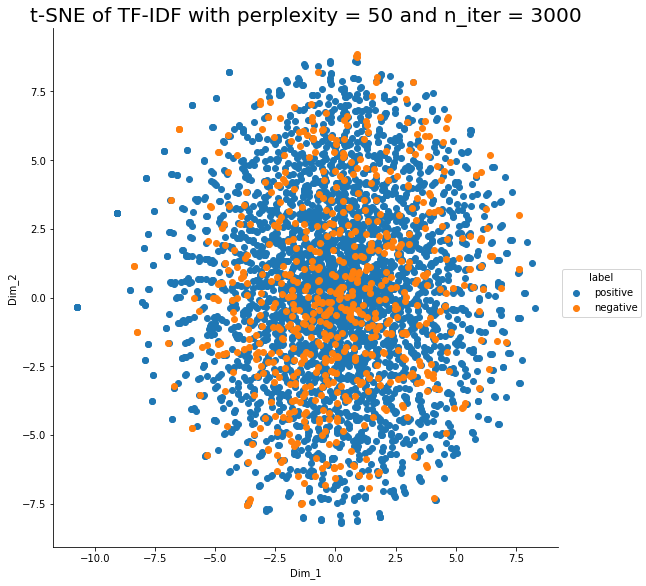

In [80]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of TF-IDF with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

OBSERVATION FOR ABOVE PLOT : From above plot it is clear that they are overlapping almost 85%-90% and it is very difficult to draw a line to classify the polarity of the reviews .

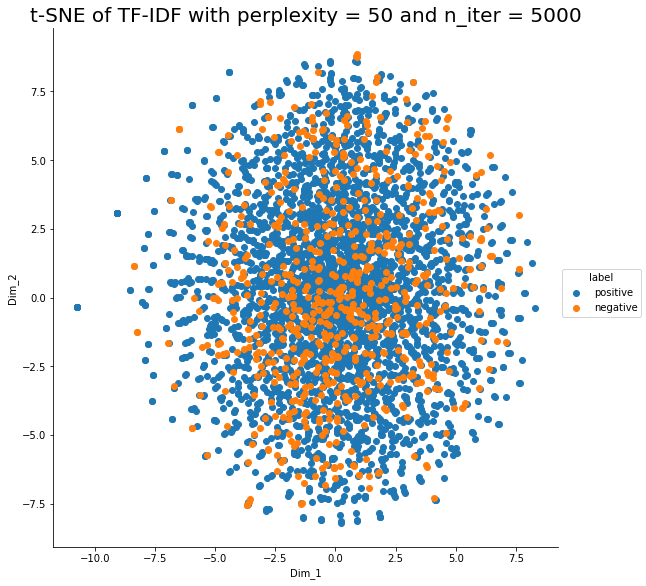

In [91]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 5000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of TF-IDF with perplexity = 50 and n_iter = 5000',size=20)
plt.show()

OBSERVATION FOR ABOVE PLOT : From above plot it is clear that they are overlapping almost 85%-90% and it is very difficult to draw a line to classify the polarity of the reviews .

#  Word2Vec

In [93]:
# Train your own Word2Vec model using your own text corpus
list_of_sent=[]
for sent in my_final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [94]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

product archer farm best drink mix ever mix flavor packet water bottl contain natur sweetner stevia real fruit flavor food color color fruit veget color pure natur tast great eight packet box contain calori per packet thank archer farm
*****************************************************************
['product', 'archer', 'farm', 'best', 'drink', 'mix', 'ever', 'mix', 'flavor', 'packet', 'water', 'bottl', 'contain', 'natur', 'sweetner', 'stevia', 'real', 'fruit', 'flavor', 'food', 'color', 'color', 'fruit', 'veget', 'color', 'pure', 'natur', 'tast', 'great', 'eight', 'packet', 'box', 'contain', 'calori', 'per', 'packet', 'thank', 'archer', 'farm']


In [95]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [98]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  3253


# (3). Avg Word2Vec

In [99]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

4000
50


In [101]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)

(4000, 50)


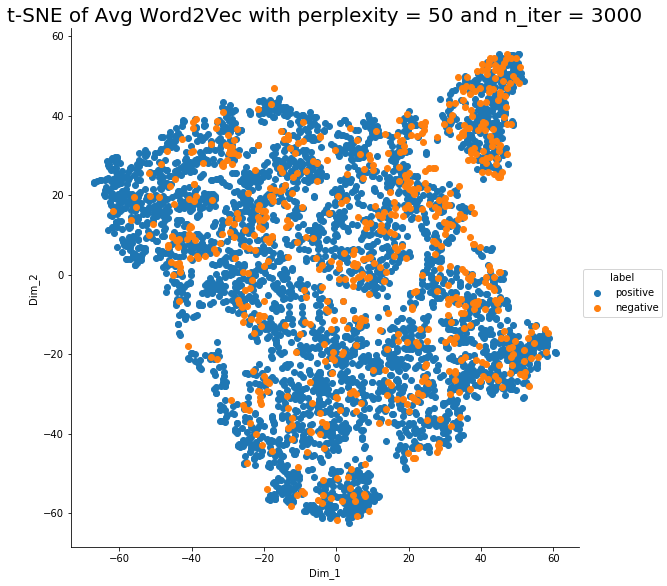

In [102]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Avg Word2Vec with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

OBSERVATION FOR ABOVE PLOT : From above plot it is clear that they are overlapping almost 80%-85% and it is very difficult to draw a line to classify the polarity of the reviews . But it is better than above plots .

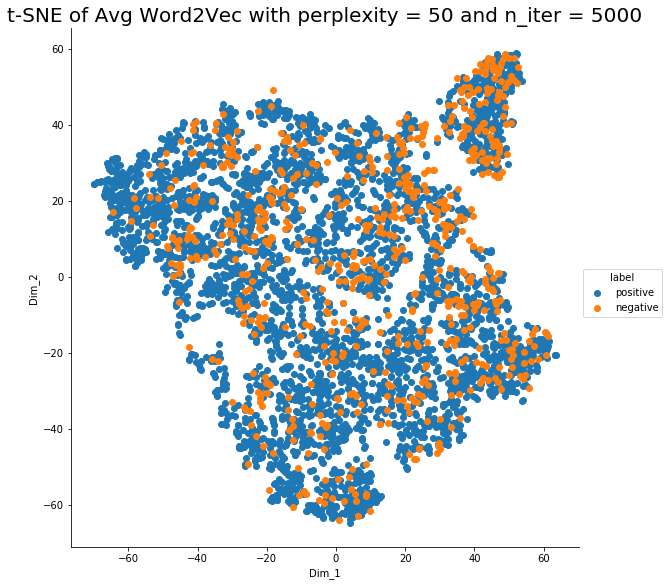

In [103]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 5000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of Avg Word2Vec with perplexity = 50 and n_iter = 5000',size=20)
plt.show()

OBSERVATION FOR ABOVE PLOT : From above plot it is clear that they are overlapping almost 80%-85% and it is very difficult to draw a line to classify the polarity of the reviews . But it is better than above plots .

# (4). TFIDF-Word2Vec

In [104]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(my_final['CleanedText'].values)

In [105]:
final_tf_idf.shape

(4000, 9454)

In [106]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

In [107]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [108]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)

(4000, 50)


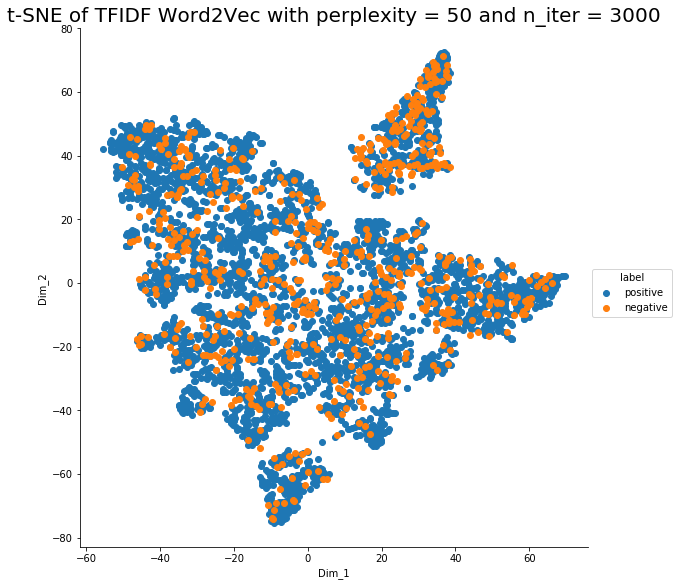

In [109]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 3000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=3000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of TFIDF Word2Vec with perplexity = 50 and n_iter = 3000',size=20)
plt.show()

OBSERVATION FOR ABOVE PLOT : From above plot it is clear that they are overlapping almost 70%-80% and it is very difficult to draw a line to classify the polarity of the reviews . But it is better than above plots .

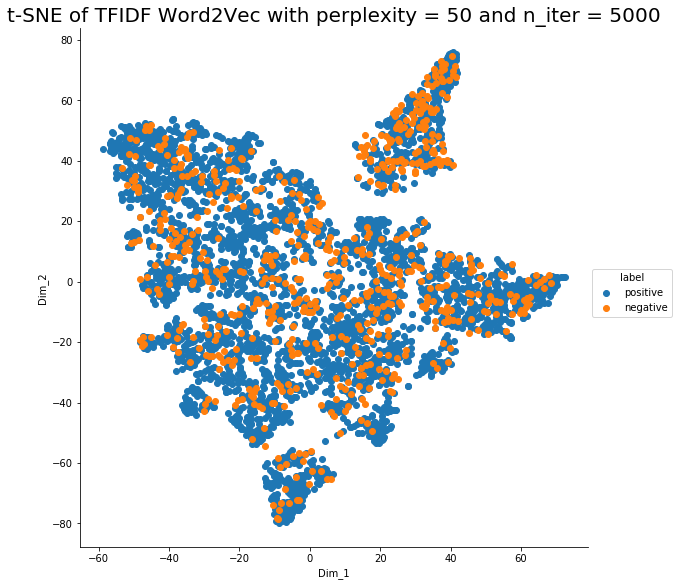

In [110]:
# TSNE

from sklearn.manifold import TSNE

# t-SNE with perplexity = 50 and n_iter = 5000
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, my_final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE of TFIDF Word2Vec with perplexity = 50 and n_iter = 5000',size=20)
plt.show()

OBSERVATION FOR ABOVE PLOT : From above plot it is clear that they are overlapping almost 70%-80% and it is very difficult to draw a line to classify the polarity of the reviews . But it is much better than above plots .